# Compare albedo

Author: Ziqi Yin

Last modified: 2025 Feb 2

Table of contents:
* [Time series of monthly mean albedo](#first-bullet)
* [Scatter plot of JJA albedo and temperature](#second-bullet)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point
from scipy import interpolate
import glob

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')

from functions import *
#from Plot_2D import Plot_2D # To draw plots
#import matplotlib.cm as cm # To change colormap used in plots

crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

# For unstructured grid
#import datashader as ds
#import datashader.utils as du
#import geoviews as gv
#import geoviews.feature as gf
#import holoviews as hv
#from datashader import reductions as rd, transfer_functions as tf
from holoviews.operation.datashader import datashade, rasterize, regrid
#from scipy.spatial import Delaunay
#hv.extension("bokeh")
import warnings
warnings.filterwarnings('ignore')

from matplotlib.collections import PolyCollection

# For regridding
import os
import ESMF
import xesmf as xe

# For creating ERA5 GrIS mask
import geopandas as gp
import matplotlib.patheffects as pe
import pooch
import regionmask

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import pyproj

# Polynomial regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
## Parameter
g = 9.80616 #[m/s2]

## 1. Time series of monthly mean albedo <a class="anchor" id="first-bullet"></a>

### Read data

In [5]:
## f09muntjewerf
# 1pctCO2
data_dir1 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/atm/proc/tseries/month_1/'
data_dir2 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/'

f09_1pctCO2_p1_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSDS.000101-005012.nc')['FSDS'][:]
f09_1pctCO2_p2_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSDS.005101-010012.nc')['FSDS'][:]
f09_1pctCO2_p3_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSDS.010101-015012.nc')['FSDS'][:40*12]
f09_1pctCO2_FSDS_monthly = xr.concat([f09_1pctCO2_p1_FSDS_monthly, f09_1pctCO2_p2_FSDS_monthly, f09_1pctCO2_p3_FSDS_monthly], dim='time')
f09_1pctCO2_p1_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSA.000101-005012.nc')['FSA'][:]
f09_1pctCO2_p2_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSA.005101-010012.nc')['FSA'][:]
f09_1pctCO2_p3_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSA.010101-015012.nc')['FSA'][:40*12]
f09_1pctCO2_FSA_monthly = xr.concat([f09_1pctCO2_p1_FSA_monthly, f09_1pctCO2_p2_FSA_monthly, f09_1pctCO2_p3_FSA_monthly], dim='time')
f09_1pctCO2_p1_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.PCT_LANDUNIT.000101-005012.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_1pctCO2_p2_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.PCT_LANDUNIT.005101-010012.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_1pctCO2_p3_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.PCT_LANDUNIT.010101-015012.nc')['PCT_LANDUNIT'][:40*12,3,:,:]
f09_1pctCO2_PCT_LANDUNIT_monthly = xr.concat([f09_1pctCO2_p1_PCT_LANDUNIT_monthly, f09_1pctCO2_p2_PCT_LANDUNIT_monthly, f09_1pctCO2_p3_PCT_LANDUNIT_monthly], dim='time')

# 4xCO2
data_dir1 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/atm/proc/tseries/month_1/'
data_dir2 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/lnd/proc/tseries/month_1/'

f09_4xext_p1_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSDS.014101-019012.nc')['FSDS'][:]
f09_4xext_p2_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSDS.019101-024012.nc')['FSDS'][:]
f09_4xext_p3_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSDS.024101-029012.nc')['FSDS'][:]
f09_4xext_p4_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSDS.029101-034012.nc')['FSDS'][:]
f09_4xext_p5_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSDS.034101-035012.nc')['FSDS'][:]
f09_4xext_FSDS_monthly = xr.concat([f09_4xext_p1_FSDS_monthly, f09_4xext_p2_FSDS_monthly, f09_4xext_p3_FSDS_monthly, f09_4xext_p4_FSDS_monthly, f09_4xext_p5_FSDS_monthly], dim='time')
f09_4xext_p1_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSA.014101-019012.nc')['FSA'][:]
f09_4xext_p2_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSA.019101-024012.nc')['FSA'][:]
f09_4xext_p3_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSA.024101-029012.nc')['FSA'][:]
f09_4xext_p4_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSA.029101-034012.nc')['FSA'][:]
f09_4xext_p5_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSA.034101-035012.nc')['FSA'][:]
f09_4xext_FSA_monthly = xr.concat([f09_4xext_p1_FSA_monthly, f09_4xext_p2_FSA_monthly, f09_4xext_p3_FSA_monthly, f09_4xext_p4_FSA_monthly, f09_4xext_p5_FSA_monthly], dim='time')
f09_4xext_p1_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.PCT_LANDUNIT.014101-019012.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_4xext_p2_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.PCT_LANDUNIT.019101-024012.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_4xext_p3_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.PCT_LANDUNIT.024101-029012.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_4xext_p4_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.PCT_LANDUNIT.029101-034012.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_4xext_p5_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.PCT_LANDUNIT.034101-035012.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_4xext_PCT_LANDUNIT_monthly = xr.concat([f09_4xext_p1_PCT_LANDUNIT_monthly, f09_4xext_p2_PCT_LANDUNIT_monthly, f09_4xext_p3_PCT_LANDUNIT_monthly, f09_4xext_p4_PCT_LANDUNIT_monthly, f09_4xext_p5_PCT_LANDUNIT_monthly], dim='time')

In [6]:
## f09nohacks
# 1pctCO2
data_dir = '/glade/work/ziqiyin/2022-VR-dynamic-GrIS/github/data/F09/upload/1pctCO2/'

f09_nohacks_1pctCO2_FSDS_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G1PCT_f09_g17_2160pes_230303_test0.clm2.h0.FSDS.nc')['FSDS'][:]
f09_nohacks_1pctCO2_FSR_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G1PCT_f09_g17_2160pes_230303_test0.clm2.h0.FSR.nc')['FSR'][:]
f09_nohacks_1pctCO2_FSA_monthly = f09_nohacks_1pctCO2_FSDS_monthly - f09_nohacks_1pctCO2_FSR_monthly
f09_nohacks_1pctCO2_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G1PCT_f09_g17_2160pes_230303_test0.clm2.h0.PCT_LANDUNIT.nc')['PCT_LANDUNIT'][:,3,:,:]

# 4xext
data_dir = '/glade/work/ziqiyin/2022-VR-dynamic-GrIS/github/data/F09/upload/4xext/'

f09_nohacks_4xext_TREFHT_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G4XCO2_f09_g17_2160pes_230324.cam.h0.TREFHT.nc')['TREFHT'][:]
f09_nohacks_4xext_FSDS_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G4XCO2_f09_g17_2160pes_230324.clm2.h0.FSDS.nc')['FSDS'][:]
f09_nohacks_4xext_FSR_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G4XCO2_f09_g17_2160pes_230324.clm2.h0.FSR.nc')['FSR'][:]
f09_nohacks_4xext_FSA_monthly = f09_nohacks_4xext_FSDS_monthly - f09_nohacks_4xext_FSR_monthly
f09_nohacks_4xext_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G4XCO2_f09_g17_2160pes_230324.clm2.h0.PCT_LANDUNIT.nc')['PCT_LANDUNIT'][:,3,:,:]

In [7]:
## Arctic grid
# 1pctCO2
data_dir = '/glade/work/ziqiyin/2022-VR-dynamic-GrIS/github/data/ARCTIC/upload/1pctCO2/'

ARCTIC_1pctCO2_FSDS_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.FSDS.nc')['FSDS'][:]
ARCTIC_1pctCO2_FSA_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.FSA.nc')['FSA'][:]
ARCTIC_1pctCO2_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.PCT_LANDUNIT.nc')['PCT_LANDUNIT'][:,3,:]

# 4xext
data_dir = '/glade/work/ziqiyin/2022-VR-dynamic-GrIS/github/data/ARCTIC/upload/4xext/'

ARCTIC_4xext_FSDS_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.clm2.h0.FSDS.nc')['FSDS'][:]
ARCTIC_4xext_FSA_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.clm2.h0.FSA.nc')['FSA'][:]
#ARCTIC_4xext_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.clm2.h0.PCT_LANDUNIT.nc')['PCT_LANDUNIT'][:,3,:] #Error file

In [8]:
## Concat
f09_1pctCO2_4xext_FSDS_monthly = xr.concat([f09_1pctCO2_FSDS_monthly, f09_4xext_FSDS_monthly], dim='time')
f09_1pctCO2_4xext_FSA_monthly = xr.concat([f09_1pctCO2_FSA_monthly, f09_4xext_FSA_monthly], dim='time')
f09_glacier_frac_monthly = xr.concat([f09_1pctCO2_PCT_LANDUNIT_monthly, f09_4xext_PCT_LANDUNIT_monthly], dim='time')

f09_nohacks_1pctCO2_4xext_FSDS_monthly = xr.concat([f09_nohacks_1pctCO2_FSDS_monthly, f09_nohacks_4xext_FSDS_monthly], dim='time')
f09_nohacks_1pctCO2_4xext_FSA_monthly = xr.concat([f09_nohacks_1pctCO2_FSA_monthly, f09_nohacks_4xext_FSA_monthly], dim='time')
f09_nohacks_glacier_frac_monthly = xr.concat([f09_nohacks_1pctCO2_PCT_LANDUNIT_monthly, f09_nohacks_4xext_PCT_LANDUNIT_monthly], dim='time')

ARCTIC_1pctCO2_4xext_FSDS_monthly = xr.concat([ARCTIC_1pctCO2_FSDS_monthly, ARCTIC_4xext_FSDS_monthly], dim='time')
ARCTIC_1pctCO2_4xext_FSA_monthly = xr.concat([ARCTIC_1pctCO2_FSA_monthly, ARCTIC_4xext_FSA_monthly], dim='time')
#ARCTIC_glacier_frac_monthly = xr.concat([ARCTIC_1pctCO2_PCT_LANDUNIT_monthly, ARCTIC_4xext_PCT_LANDUNIT_monthly], dim='time')

In [9]:
## Area and land fraction
Re = 6371.22 * 1e3 #[m]

f09_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file1)['area'] #[Radian2]
f09_area = f09_area.values * Re**2

ARCTIC_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file1)['area'] #[Radian2]
ARCTIC_area = ARCTIC_area.values * Re**2

In [10]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
#f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
#f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
#f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
#f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
#ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
#ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
#ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
#ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
#ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
#ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
#ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
#ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

In [11]:
ARCTIC_glacier_frac_4xext_monthly = np.zeros([210*12, 117398])

for i in range(210):
    ARCTIC_glacier_frac_4xext_monthly[12*i:12*i+12,:] = ARCTIC_glacier_frac_4xext[i]

In [12]:
# monthly
f09_1pctCO2_4xext_GrIS_mask_monthly = f09_GrIS_mask0.values * f09_glacier_frac_monthly.values * f09_land_frac.values / 100

f09_nohacks_1pctCO2_4xext_GrIS_mask_monthly = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_monthly.values * f09_land_frac.values / 100

ARCTIC_1pctCO2_GrIS_mask_monthly = ARCTIC_GrIS_mask0.values * ARCTIC_1pctCO2_PCT_LANDUNIT_monthly.values * ARCTIC_land_frac.values / 100
ARCTIC_4xext_GrIS_mask_monthly = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_4xext_monthly * ARCTIC_land_frac.values / 100
ARCTIC_1pctCO2_4xext_GrIS_mask_monthly = np.concatenate((ARCTIC_1pctCO2_GrIS_mask_monthly, ARCTIC_4xext_GrIS_mask_monthly), axis=0)

### Calculate

In [13]:
## Albedo
f09_1pctCO2_4xext_albedo_monthly = (f09_1pctCO2_4xext_FSDS_monthly - f09_1pctCO2_4xext_FSA_monthly) / f09_1pctCO2_4xext_FSDS_monthly
f09_nohacks_1pctCO2_4xext_albedo_monthly = (f09_nohacks_1pctCO2_4xext_FSDS_monthly - f09_nohacks_1pctCO2_4xext_FSA_monthly) / f09_nohacks_1pctCO2_4xext_FSDS_monthly
ARCTIC_1pctCO2_4xext_albedo_monthly = (ARCTIC_1pctCO2_4xext_FSDS_monthly - ARCTIC_1pctCO2_4xext_FSA_monthly) / ARCTIC_1pctCO2_4xext_FSDS_monthly

In [108]:
## Select month
# glacier fraction is the same in one year
f09_1pctCO2_4xext_GrIS_mask = f09_1pctCO2_4xext_GrIS_mask_monthly[0::12]
f09_nohacks_1pctCO2_4xext_GrIS_mask = f09_nohacks_1pctCO2_4xext_GrIS_mask_monthly[0::12]
ARCTIC_1pctCO2_4xext_GrIS_mask = ARCTIC_1pctCO2_4xext_GrIS_mask_monthly[0::12]

# April
f09_1pctCO2_4xext_albedo_Apr = f09_1pctCO2_4xext_albedo_monthly[3::12]
f09_nohacks_1pctCO2_4xext_albedo_Apr = f09_nohacks_1pctCO2_4xext_albedo_monthly[3::12]
ARCTIC_1pctCO2_4xext_albedo_Apr = ARCTIC_1pctCO2_4xext_albedo_monthly[3::12]

# May
f09_1pctCO2_4xext_albedo_May = f09_1pctCO2_4xext_albedo_monthly[4::12]
f09_nohacks_1pctCO2_4xext_albedo_May = f09_nohacks_1pctCO2_4xext_albedo_monthly[4::12]
ARCTIC_1pctCO2_4xext_albedo_May = ARCTIC_1pctCO2_4xext_albedo_monthly[4::12]

# June
f09_1pctCO2_4xext_albedo_Jun = f09_1pctCO2_4xext_albedo_monthly[5::12]
f09_nohacks_1pctCO2_4xext_albedo_Jun = f09_nohacks_1pctCO2_4xext_albedo_monthly[5::12]
ARCTIC_1pctCO2_4xext_albedo_Jun = ARCTIC_1pctCO2_4xext_albedo_monthly[5::12]

# August
f09_1pctCO2_4xext_albedo_Aug = f09_1pctCO2_4xext_albedo_monthly[7::12]
f09_nohacks_1pctCO2_4xext_albedo_Aug = f09_nohacks_1pctCO2_4xext_albedo_monthly[7::12]
ARCTIC_1pctCO2_4xext_albedo_Aug = ARCTIC_1pctCO2_4xext_albedo_monthly[7::12]

In [109]:
## Average value
f09_1pctCO2_4xext_GrIS_area = np.nansum(f09_1pctCO2_4xext_GrIS_mask * f09_area, axis=(1,2))
f09_nohacks_1pctCO2_4xext_GrIS_area = np.nansum(f09_nohacks_1pctCO2_4xext_GrIS_mask * f09_area, axis=(1,2))
ARCTIC_1pctCO2_4xext_GrIS_area = np.nansum(ARCTIC_1pctCO2_4xext_GrIS_mask * ARCTIC_area, axis=1)

# April
f09_1pctCO2_4xext_avg_albedo_Apr = (f09_1pctCO2_4xext_albedo_Apr * f09_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_albedo_Apr = (f09_nohacks_1pctCO2_4xext_albedo_Apr * f09_nohacks_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_albedo_Apr = (ARCTIC_1pctCO2_4xext_albedo_Apr * ARCTIC_1pctCO2_4xext_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area

# May
f09_1pctCO2_4xext_avg_albedo_May = (f09_1pctCO2_4xext_albedo_May * f09_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_albedo_May = (f09_nohacks_1pctCO2_4xext_albedo_May * f09_nohacks_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_albedo_May = (ARCTIC_1pctCO2_4xext_albedo_May * ARCTIC_1pctCO2_4xext_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area

# June
f09_1pctCO2_4xext_avg_albedo_Jun = (f09_1pctCO2_4xext_albedo_Jun * f09_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_albedo_Jun = (f09_nohacks_1pctCO2_4xext_albedo_Jun * f09_nohacks_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_albedo_Jun = (ARCTIC_1pctCO2_4xext_albedo_Jun * ARCTIC_1pctCO2_4xext_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area

# August
f09_1pctCO2_4xext_avg_albedo_Aug = (f09_1pctCO2_4xext_albedo_Aug * f09_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_albedo_Aug = (f09_nohacks_1pctCO2_4xext_albedo_Aug * f09_nohacks_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_albedo_Aug = (ARCTIC_1pctCO2_4xext_albedo_Aug * ARCTIC_1pctCO2_4xext_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area

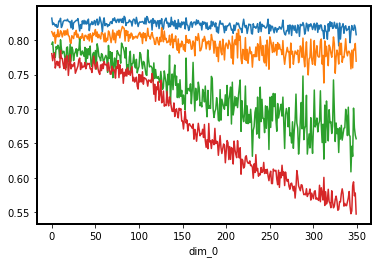

In [110]:
## Test
xr.DataArray(f09_1pctCO2_4xext_avg_albedo_Apr.values).plot();
xr.DataArray(f09_1pctCO2_4xext_avg_albedo_May.values).plot();
xr.DataArray(f09_1pctCO2_4xext_avg_albedo_Jun.values).plot();
xr.DataArray(f09_1pctCO2_4xext_avg_albedo_Aug.values).plot();

### Plot

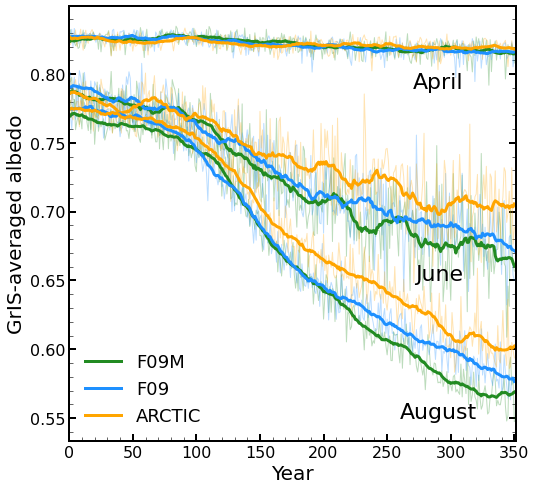

In [20]:
fig = plt.figure(figsize = (8,8))
gs=GridSpec(1,1)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18

#-------------------------------------------- ME --------------------------------------------
ax1 = plt.subplot(gs[0])

ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Apr, color='forestgreen', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Apr, color='dodgerblue', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Apr, color='orange', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Jun, color='forestgreen', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Jun, color='dodgerblue', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Jun, color='orange', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Aug, color='forestgreen', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Aug, color='dodgerblue', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Aug, color='orange', linewidth=1, alpha=0.3)

f09_1pctCO2_4xext_avg_albedo_Apr_rm = f09_1pctCO2_4xext_avg_albedo_Apr.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_1pctCO2_4xext_avg_albedo_Apr_rm = f09_nohacks_1pctCO2_4xext_avg_albedo_Apr.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_1pctCO2_4xext_avg_albedo_Apr_rm = ARCTIC_1pctCO2_4xext_avg_albedo_Apr.rolling(time=20, center=True, min_periods=2).mean()
f09_1pctCO2_4xext_avg_albedo_Jun_rm = f09_1pctCO2_4xext_avg_albedo_Jun.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_1pctCO2_4xext_avg_albedo_Jun_rm = f09_nohacks_1pctCO2_4xext_avg_albedo_Jun.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_1pctCO2_4xext_avg_albedo_Jun_rm = ARCTIC_1pctCO2_4xext_avg_albedo_Jun.rolling(time=20, center=True, min_periods=2).mean()
f09_1pctCO2_4xext_avg_albedo_Aug_rm = f09_1pctCO2_4xext_avg_albedo_Aug.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_1pctCO2_4xext_avg_albedo_Aug_rm = f09_nohacks_1pctCO2_4xext_avg_albedo_Aug.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_1pctCO2_4xext_avg_albedo_Aug_rm = ARCTIC_1pctCO2_4xext_avg_albedo_Aug.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Apr_rm, color='forestgreen', linewidth=3, label='F09M')
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Apr_rm, color='dodgerblue', linewidth=3, label='F09')
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Apr_rm, color='orange', linewidth=3, label='ARCTIC')
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Jun_rm, color='forestgreen', linewidth=3)
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Jun_rm, color='dodgerblue', linewidth=3)
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Jun_rm, color='orange', linewidth=3)
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Aug_rm, color='forestgreen', linewidth=3)
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Aug_rm, color='dodgerblue', linewidth=3)
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Aug_rm, color='orange', linewidth=3)

ax1.set_xlim([0, 351])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('GrIS-averaged albedo', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
ax1.tick_params(axis='y', which='both', right=True)

plt.text(270, 0.79, 'April', fontsize=22)
plt.text(272, 0.65, 'June', fontsize=22)
plt.text(260, 0.55, 'August', fontsize=22)

ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

plt.subplots_adjust(wspace=0.28)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_albedo_Apr_Jun_Aug.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #

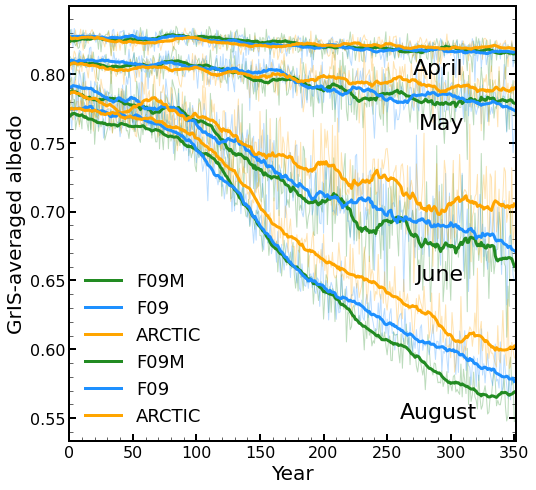

In [112]:
# April, May, June, August
fig = plt.figure(figsize = (8,8))
gs=GridSpec(1,1)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18

#-------------------------------------------- ME --------------------------------------------
ax1 = plt.subplot(gs[0])

ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Apr, color='forestgreen', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Apr, color='dodgerblue', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Apr, color='orange', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_May, color='forestgreen', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_May, color='dodgerblue', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_May, color='orange', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Jun, color='forestgreen', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Jun, color='dodgerblue', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Jun, color='orange', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Aug, color='forestgreen', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Aug, color='dodgerblue', linewidth=1, alpha=0.3)
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Aug, color='orange', linewidth=1, alpha=0.3)

f09_1pctCO2_4xext_avg_albedo_Apr_rm = f09_1pctCO2_4xext_avg_albedo_Apr.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_1pctCO2_4xext_avg_albedo_Apr_rm = f09_nohacks_1pctCO2_4xext_avg_albedo_Apr.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_1pctCO2_4xext_avg_albedo_Apr_rm = ARCTIC_1pctCO2_4xext_avg_albedo_Apr.rolling(time=20, center=True, min_periods=2).mean()
f09_1pctCO2_4xext_avg_albedo_May_rm = f09_1pctCO2_4xext_avg_albedo_May.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_1pctCO2_4xext_avg_albedo_May_rm = f09_nohacks_1pctCO2_4xext_avg_albedo_May.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_1pctCO2_4xext_avg_albedo_May_rm = ARCTIC_1pctCO2_4xext_avg_albedo_May.rolling(time=20, center=True, min_periods=2).mean()
f09_1pctCO2_4xext_avg_albedo_Jun_rm = f09_1pctCO2_4xext_avg_albedo_Jun.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_1pctCO2_4xext_avg_albedo_Jun_rm = f09_nohacks_1pctCO2_4xext_avg_albedo_Jun.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_1pctCO2_4xext_avg_albedo_Jun_rm = ARCTIC_1pctCO2_4xext_avg_albedo_Jun.rolling(time=20, center=True, min_periods=2).mean()
f09_1pctCO2_4xext_avg_albedo_Aug_rm = f09_1pctCO2_4xext_avg_albedo_Aug.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_1pctCO2_4xext_avg_albedo_Aug_rm = f09_nohacks_1pctCO2_4xext_avg_albedo_Aug.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_1pctCO2_4xext_avg_albedo_Aug_rm = ARCTIC_1pctCO2_4xext_avg_albedo_Aug.rolling(time=20, center=True, min_periods=2).mean()

ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Apr_rm, color='forestgreen', linewidth=3, label='F09M')
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Apr_rm, color='dodgerblue', linewidth=3, label='F09')
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Apr_rm, color='orange', linewidth=3, label='ARCTIC')
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_May_rm, color='forestgreen', linewidth=3, label='F09M')
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_May_rm, color='dodgerblue', linewidth=3, label='F09')
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_May_rm, color='orange', linewidth=3, label='ARCTIC')
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Jun_rm, color='forestgreen', linewidth=3)
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Jun_rm, color='dodgerblue', linewidth=3)
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Jun_rm, color='orange', linewidth=3)
ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_avg_albedo_Aug_rm, color='forestgreen', linewidth=3)
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_avg_albedo_Aug_rm, color='dodgerblue', linewidth=3)
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_avg_albedo_Aug_rm, color='orange', linewidth=3)

ax1.set_xlim([0, 351])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('GrIS-averaged albedo', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
ax1.tick_params(axis='y', which='both', right=True)

plt.text(270, 0.80, 'April', fontsize=22)
plt.text(275, 0.76, 'May', fontsize=22)
plt.text(272, 0.65, 'June', fontsize=22)
plt.text(260, 0.55, 'August', fontsize=22)

ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

plt.subplots_adjust(wspace=0.28)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_albedo_Apr_May_Jun_Aug.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False) #

## 2. JJA albedo vs temperature <a class="anchor" id="second-bullet"></a>

### Read data

#### 1pctCO2+4xext

In [71]:
## f09muntjewerf
# 1pctCO2
data_dir1 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/atm/proc/tseries/month_1/'
data_dir2 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/'

f09_1pctCO2_p1_TREFHT_monthly = xr.open_dataset(data_dir1+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cam.h0.TREFHT.000101-005012.nc')['TREFHT'][:]
f09_1pctCO2_p2_TREFHT_monthly = xr.open_dataset(data_dir1+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cam.h0.TREFHT.005101-010012.nc')['TREFHT'][:]
f09_1pctCO2_p3_TREFHT_monthly = xr.open_dataset(data_dir1+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cam.h0.TREFHT.010101-015012.nc')['TREFHT'][:40*12]
f09_1pctCO2_TREFHT_monthly = xr.concat([f09_1pctCO2_p1_TREFHT_monthly, f09_1pctCO2_p2_TREFHT_monthly, f09_1pctCO2_p3_TREFHT_monthly], dim='time')
f09_1pctCO2_p1_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSDS.000101-005012.nc')['FSDS'][:]
f09_1pctCO2_p2_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSDS.005101-010012.nc')['FSDS'][:]
f09_1pctCO2_p3_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSDS.010101-015012.nc')['FSDS'][:40*12]
f09_1pctCO2_FSDS_monthly = xr.concat([f09_1pctCO2_p1_FSDS_monthly, f09_1pctCO2_p2_FSDS_monthly, f09_1pctCO2_p3_FSDS_monthly], dim='time')
f09_1pctCO2_p1_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSA.000101-005012.nc')['FSA'][:]
f09_1pctCO2_p2_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSA.005101-010012.nc')['FSA'][:]
f09_1pctCO2_p3_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.FSA.010101-015012.nc')['FSA'][:40*12]
f09_1pctCO2_FSA_monthly = xr.concat([f09_1pctCO2_p1_FSA_monthly, f09_1pctCO2_p2_FSA_monthly, f09_1pctCO2_p3_FSA_monthly], dim='time')
#f09_1pctCO2_p1_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.PCT_LANDUNIT.000101-005012.nc')['PCT_LANDUNIT'][:,3,:,:]
#f09_1pctCO2_p2_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.PCT_LANDUNIT.005101-010012.nc')['PCT_LANDUNIT'][:,3,:,:]
#f09_1pctCO2_p3_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.PCT_LANDUNIT.010101-015012.nc')['PCT_LANDUNIT'][:40*12,3,:,:]
#f09_1pctCO2_PCT_LANDUNIT_monthly = xr.concat([f09_1pctCO2_p1_PCT_LANDUNIT_monthly, f09_1pctCO2_p2_PCT_LANDUNIT_monthly, f09_1pctCO2_p3_PCT_LANDUNIT_monthly], dim='time')

# 4xCO2
data_dir1 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/atm/proc/tseries/month_1/'
data_dir2 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/lnd/proc/tseries/month_1/'

f09_4xext_p1_TREFHT_monthly = xr.open_dataset(data_dir1+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cam.h0.TREFHT.014101-019012.nc')['TREFHT'][:]
f09_4xext_p2_TREFHT_monthly = xr.open_dataset(data_dir1+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cam.h0.TREFHT.019101-024012.nc')['TREFHT'][:]
f09_4xext_p3_TREFHT_monthly = xr.open_dataset(data_dir1+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cam.h0.TREFHT.024101-029012.nc')['TREFHT'][:]
f09_4xext_p4_TREFHT_monthly = xr.open_dataset(data_dir1+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cam.h0.TREFHT.029101-034012.nc')['TREFHT'][:]
f09_4xext_p5_TREFHT_monthly = xr.open_dataset(data_dir1+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cam.h0.TREFHT.034101-035012.nc')['TREFHT'][:]
f09_4xext_TREFHT_monthly = xr.concat([f09_4xext_p1_TREFHT_monthly, f09_4xext_p2_TREFHT_monthly, f09_4xext_p3_TREFHT_monthly, f09_4xext_p4_TREFHT_monthly, f09_4xext_p5_TREFHT_monthly], dim='time')
f09_4xext_p1_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSDS.014101-019012.nc')['FSDS'][:]
f09_4xext_p2_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSDS.019101-024012.nc')['FSDS'][:]
f09_4xext_p3_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSDS.024101-029012.nc')['FSDS'][:]
f09_4xext_p4_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSDS.029101-034012.nc')['FSDS'][:]
f09_4xext_p5_FSDS_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSDS.034101-035012.nc')['FSDS'][:]
f09_4xext_FSDS_monthly = xr.concat([f09_4xext_p1_FSDS_monthly, f09_4xext_p2_FSDS_monthly, f09_4xext_p3_FSDS_monthly, f09_4xext_p4_FSDS_monthly, f09_4xext_p5_FSDS_monthly], dim='time')
f09_4xext_p1_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSA.014101-019012.nc')['FSA'][:]
f09_4xext_p2_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSA.019101-024012.nc')['FSA'][:]
f09_4xext_p3_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSA.024101-029012.nc')['FSA'][:]
f09_4xext_p4_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSA.029101-034012.nc')['FSA'][:]
f09_4xext_p5_FSA_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.FSA.034101-035012.nc')['FSA'][:]
f09_4xext_FSA_monthly = xr.concat([f09_4xext_p1_FSA_monthly, f09_4xext_p2_FSA_monthly, f09_4xext_p3_FSA_monthly, f09_4xext_p4_FSA_monthly, f09_4xext_p5_FSA_monthly], dim='time')
#f09_4xext_p1_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.PCT_LANDUNIT.014101-019012.nc')['PCT_LANDUNIT'][:,3,:,:]
#f09_4xext_p2_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.PCT_LANDUNIT.019101-024012.nc')['PCT_LANDUNIT'][:,3,:,:]
#f09_4xext_p3_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.PCT_LANDUNIT.024101-029012.nc')['PCT_LANDUNIT'][:,3,:,:]
#f09_4xext_p4_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.PCT_LANDUNIT.029101-034012.nc')['PCT_LANDUNIT'][:,3,:,:]
#f09_4xext_p5_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir2+'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.clm2.h0.PCT_LANDUNIT.034101-035012.nc')['PCT_LANDUNIT'][:,3,:,:]
#f09_4xext_PCT_LANDUNIT_monthly = xr.concat([f09_4xext_p1_PCT_LANDUNIT_monthly, f09_4xext_p2_PCT_LANDUNIT_monthly, f09_4xext_p3_PCT_LANDUNIT_monthly, f09_4xext_p4_PCT_LANDUNIT_monthly, f09_4xext_p5_PCT_LANDUNIT_monthly], dim='time')

In [72]:
## f09nohacks
# 1pctCO2
data_dir = '/glade/work/ziqiyin/2022-VR-dynamic-GrIS/github/data/F09/upload/1pctCO2/'

f09_nohacks_1pctCO2_TREFHT_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G1PCT_f09_g17_2160pes_230303_test0.cam.h0.TREFHT.nc')['TREFHT'][:]
f09_nohacks_1pctCO2_FSDS_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G1PCT_f09_g17_2160pes_230303_test0.clm2.h0.FSDS.nc')['FSDS'][:]
f09_nohacks_1pctCO2_FSR_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G1PCT_f09_g17_2160pes_230303_test0.clm2.h0.FSR.nc')['FSR'][:]
f09_nohacks_1pctCO2_FSA_monthly = f09_nohacks_1pctCO2_FSDS_monthly - f09_nohacks_1pctCO2_FSR_monthly
#f09_nohacks_1pctCO2_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G1PCT_f09_g17_2160pes_230303_test0.clm2.h0.PCT_LANDUNIT.nc')['PCT_LANDUNIT'][:,3,:,:]

# 4xext
data_dir = '/glade/work/ziqiyin/2022-VR-dynamic-GrIS/github/data/F09/upload/4xext/'

f09_nohacks_4xext_TREFHT_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G4XCO2_f09_g17_2160pes_230324.cam.h0.TREFHT.nc')['TREFHT'][:]
f09_nohacks_4xext_FSDS_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G4XCO2_f09_g17_2160pes_230324.clm2.h0.FSDS.nc')['FSDS'][:]
f09_nohacks_4xext_FSR_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G4XCO2_f09_g17_2160pes_230324.clm2.h0.FSR.nc')['FSR'][:]
f09_nohacks_4xext_FSA_monthly = f09_nohacks_4xext_FSDS_monthly - f09_nohacks_4xext_FSR_monthly
#f09_nohacks_4xext_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir+'release-cesm2.1.3.cism_B1850G4XCO2_f09_g17_2160pes_230324.clm2.h0.PCT_LANDUNIT.nc')['PCT_LANDUNIT'][:,3,:,:]

In [73]:
## Arctic grid
# piControl
data_dir = '/glade/work/ziqiyin/2022-VR-dynamic-GrIS/github/data/ARCTIC/upload/piControl/'

ARCTIC_piControl_p4_TREFHT_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G_ne0ARCTICne30x4_g17_8192pes_210902_yr101hybrid_192NCPL_atm-aoflux_tuned_jgbgcismnl_Nx1yrs.cam.h1.TREFHT.nc')['TREFHT'][:]
ARCTIC_piControl_p4_FSDS_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G_ne0ARCTICne30x4_g17_8192pes_210902_yr101hybrid_192NCPL_atm-aoflux_tuned_jgbgcismnl_Nx1yrs.clm2.h0.FSDS.nc')['FSDS'][:]
ARCTIC_piControl_p4_FSA_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G_ne0ARCTICne30x4_g17_8192pes_210902_yr101hybrid_192NCPL_atm-aoflux_tuned_jgbgcismnl_Nx1yrs.clm2.h0.FSA.nc')['FSA'][:]

In [74]:
## Arctic grid
# 1pctCO2
data_dir = '/glade/work/ziqiyin/2022-VR-dynamic-GrIS/github/data/ARCTIC/upload/1pctCO2/'

ARCTIC_1pctCO2_TREFHT_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.cam.h1.TREFHT.nc')['TREFHT'][:]
ARCTIC_1pctCO2_FSDS_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.FSDS.nc')['FSDS'][:]
ARCTIC_1pctCO2_FSA_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.FSA.nc')['FSA'][:]
#ARCTIC_1pctCO2_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.PCT_LANDUNIT.nc')['PCT_LANDUNIT'][:,3,:]

# 4xext
data_dir = '/glade/work/ziqiyin/2022-VR-dynamic-GrIS/github/data/ARCTIC/upload/4xext/'

ARCTIC_4xext_TREFHT_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.cam.h1.TREFHT.nc')['TREFHT'][:]
ARCTIC_4xext_FSDS_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.clm2.h0.FSDS.nc')['FSDS'][:]
ARCTIC_4xext_FSA_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.clm2.h0.FSA.nc')['FSA'][:]
#ARCTIC_4xext_PCT_LANDUNIT_monthly = xr.open_dataset(data_dir+'cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.clm2.h0.PCT_LANDUNIT.nc')['PCT_LANDUNIT'][:,3,:] #Error file

In [75]:
## Concat
f09_1pctCO2_4xext_TREFHT_monthly = xr.concat([f09_1pctCO2_TREFHT_monthly, f09_4xext_TREFHT_monthly], dim='time')
f09_1pctCO2_4xext_FSDS_monthly = xr.concat([f09_1pctCO2_FSDS_monthly, f09_4xext_FSDS_monthly], dim='time')
f09_1pctCO2_4xext_FSA_monthly = xr.concat([f09_1pctCO2_FSA_monthly, f09_4xext_FSA_monthly], dim='time')
#f09_glacier_frac_monthly = xr.concat([f09_1pctCO2_PCT_LANDUNIT_monthly, f09_4xext_PCT_LANDUNIT_monthly], dim='time')

f09_nohacks_1pctCO2_4xext_TREFHT_monthly = xr.concat([f09_nohacks_1pctCO2_TREFHT_monthly, f09_nohacks_4xext_TREFHT_monthly], dim='time')
f09_nohacks_1pctCO2_4xext_FSDS_monthly = xr.concat([f09_nohacks_1pctCO2_FSDS_monthly, f09_nohacks_4xext_FSDS_monthly], dim='time')
f09_nohacks_1pctCO2_4xext_FSA_monthly = xr.concat([f09_nohacks_1pctCO2_FSA_monthly, f09_nohacks_4xext_FSA_monthly], dim='time')
#f09_nohacks_glacier_frac_monthly = xr.concat([f09_nohacks_1pctCO2_PCT_LANDUNIT_monthly, f09_nohacks_4xext_PCT_LANDUNIT_monthly], dim='time')

ARCTIC_1pctCO2_4xext_TREFHT_monthly = xr.concat([ARCTIC_1pctCO2_TREFHT_monthly, ARCTIC_4xext_TREFHT_monthly], dim='time')
ARCTIC_1pctCO2_4xext_FSDS_monthly = xr.concat([ARCTIC_1pctCO2_FSDS_monthly, ARCTIC_4xext_FSDS_monthly], dim='time')
ARCTIC_1pctCO2_4xext_FSA_monthly = xr.concat([ARCTIC_1pctCO2_FSA_monthly, ARCTIC_4xext_FSA_monthly], dim='time')
#ARCTIC_glacier_frac_monthly = xr.concat([ARCTIC_1pctCO2_PCT_LANDUNIT_monthly, ARCTIC_4xext_PCT_LANDUNIT_monthly], dim='time')

##### Read in virtual temperature fields

In [78]:
data_dir = home_dir+'/2022-VR-dynamic-GrIS/github/data/processed/'

f09_1pctCO2_4xext_Tv_JJA = xr.open_dataset(data_dir+"F09M_1pctCO2_4xext_Tv_500_1000hPa_JJA.nc")['Tv_500_1000hPa']
f09_nohacks_1pctCO2_4xext_Tv_JJA = xr.open_dataset(data_dir+"F09_1pctCO2_4xext_Tv_500_1000hPa_JJA.nc")['Tv_500_1000hPa']
ARCTIC_1pctCO2_4xext_Tv_JJA = xr.open_dataset(data_dir+"ARCTIC_1pctCO2_4xext_Tv_500_1000hPa_JJA.nc")['Tv_500_1000hPa']

#### Area and mask

In [3]:
## Area and land fraction
Re = 6371.22 * 1e3 #[m]

f09_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file1)['area'] #[Radian2]
f09_area = f09_area.values * Re**2

ARCTIC_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file1)['area'] #[Radian2]
ARCTIC_area = ARCTIC_area.values * Re**2

In [4]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_1pctCO2_4xext_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_1pctCO2_4xext_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_1pctCO2_4xext_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

#### piControl

In [5]:
## piControl
# BG iteration 7
BG7_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_TREFHT_JJA_yearly.nc')['TREFHT'] #TREFHT (2m air temperature)[K]
BG7_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FSDS_JJA_yearly.nc')['FSDS']
BG7_FSA_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_FSA_JJA_yearly.nc')['FSA']

## f09nohacks
f09_nohacks_piControl_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_piControl_JJA_yearly.nc')['TREFHT']
f09_nohacks_piControl_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_piControl_JJA_yearly.nc')['FSDS'] # atmospheric incident solar radiation [W/m2] 
f09_nohacks_piControl_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_piControl_JJA_yearly.nc')['FSR'] # reflected solar radiation [W/m2] 

## Arctic grid
ARCTIC_piControl_p4_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_piControl_p4_JJA_yearly.nc')['TREFHT']
ARCTIC_piControl_p4_FSDS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_piControl_p4_JJA.nc')['FSDS']
ARCTIC_piControl_p4_FSR_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_piControl_p4_JJA.nc')['FSR']

### Calculate

#### 1pctCO2+4xext

In [80]:
## Albedo
f09_1pctCO2_4xext_albedo_monthly = (f09_1pctCO2_4xext_FSDS_monthly - f09_1pctCO2_4xext_FSA_monthly) / f09_1pctCO2_4xext_FSDS_monthly
f09_nohacks_1pctCO2_4xext_albedo_monthly = (f09_nohacks_1pctCO2_4xext_FSDS_monthly - f09_nohacks_1pctCO2_4xext_FSA_monthly) / f09_nohacks_1pctCO2_4xext_FSDS_monthly
ARCTIC_1pctCO2_4xext_albedo_monthly = (ARCTIC_1pctCO2_4xext_FSDS_monthly - ARCTIC_1pctCO2_4xext_FSA_monthly) / ARCTIC_1pctCO2_4xext_FSDS_monthly

In [81]:
## Reframe time dimension
dates = pd.date_range("1851-01-01", periods=350*12, freq='M')
f09_1pctCO2_4xext_albedo_monthly['time'] = dates
f09_nohacks_1pctCO2_4xext_albedo_monthly['time'] = dates
ARCTIC_1pctCO2_4xext_albedo_monthly['time'] = dates

f09_1pctCO2_4xext_TREFHT_monthly['time'] = dates
f09_nohacks_1pctCO2_4xext_TREFHT_monthly['time'] = dates
ARCTIC_1pctCO2_4xext_TREFHT_monthly['time'] = dates

In [82]:
## JJA mean fields
months = f09_1pctCO2_4xext_albedo_monthly['time'].dt.month
f09_1pctCO2_4xext_albedo_JJA = f09_1pctCO2_4xext_albedo_monthly.where(months.isin([6,7,8])).groupby('time.year').mean('time')
f09_nohacks_1pctCO2_4xext_albedo_JJA = f09_nohacks_1pctCO2_4xext_albedo_monthly.where(months.isin([6,7,8])).groupby('time.year').mean('time')
ARCTIC_1pctCO2_4xext_albedo_JJA = ARCTIC_1pctCO2_4xext_albedo_monthly.where(months.isin([6,7,8])).groupby('time.year').mean('time')

f09_1pctCO2_4xext_TREFHT_JJA = f09_1pctCO2_4xext_TREFHT_monthly.where(months.isin([6,7,8])).groupby('time.year').mean('time')
f09_nohacks_1pctCO2_4xext_TREFHT_JJA = f09_nohacks_1pctCO2_4xext_TREFHT_monthly.where(months.isin([6,7,8])).groupby('time.year').mean('time')
ARCTIC_1pctCO2_4xext_TREFHT_JJA = ARCTIC_1pctCO2_4xext_TREFHT_monthly.where(months.isin([6,7,8])).groupby('time.year').mean('time')

In [83]:
## Average over the GrIS
f09_1pctCO2_4xext_GrIS_area = np.nansum(f09_1pctCO2_4xext_GrIS_mask * f09_area, axis=(1,2))
f09_nohacks_1pctCO2_4xext_GrIS_area = np.nansum(f09_nohacks_1pctCO2_4xext_GrIS_mask * f09_area, axis=(1,2))
ARCTIC_1pctCO2_4xext_GrIS_area = np.nansum(ARCTIC_1pctCO2_4xext_GrIS_mask * ARCTIC_area, axis=1)

# Albedo
f09_1pctCO2_4xext_avg_albedo_JJA = (f09_1pctCO2_4xext_albedo_JJA * f09_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_albedo_JJA = (f09_nohacks_1pctCO2_4xext_albedo_JJA * f09_nohacks_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_albedo_JJA = (ARCTIC_1pctCO2_4xext_albedo_JJA * ARCTIC_1pctCO2_4xext_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) / ARCTIC_1pctCO2_4xext_GrIS_area

# T2m
f09_1pctCO2_4xext_avg_TREFHT_JJA = (f09_1pctCO2_4xext_TREFHT_JJA * f09_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_TREFHT_JJA = (f09_nohacks_1pctCO2_4xext_TREFHT_JJA * f09_nohacks_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_TREFHT_JJA = (ARCTIC_1pctCO2_4xext_TREFHT_JJA * ARCTIC_1pctCO2_4xext_GrIS_mask * ARCTIC_area).sum(dim=['ncol']) / ARCTIC_1pctCO2_4xext_GrIS_area

# Tv (500-1000hPa)
f09_1pctCO2_4xext_avg_Tv_JJA = (f09_1pctCO2_4xext_Tv_JJA * f09_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_1pctCO2_4xext_GrIS_area
f09_nohacks_1pctCO2_4xext_avg_Tv_JJA = (f09_nohacks_1pctCO2_4xext_Tv_JJA * f09_nohacks_1pctCO2_4xext_GrIS_mask * f09_area).sum(dim=['lat','lon']) / f09_nohacks_1pctCO2_4xext_GrIS_area
ARCTIC_1pctCO2_4xext_avg_Tv_JJA = (ARCTIC_1pctCO2_4xext_Tv_JJA * ARCTIC_1pctCO2_4xext_GrIS_mask * ARCTIC_area).sum(dim=['ncol']) / ARCTIC_1pctCO2_4xext_GrIS_area

In [127]:
## Save as netcdf file
# Combine the DataArrays into a Dataset
year = f09_1pctCO2_4xext_avg_TREFHT_JJA['year'].values
f09_1pctCO2_4xext_avg_Tv_JJA['year'] = year
f09_nohacks_1pctCO2_4xext_avg_Tv_JJA['year'] = year
ARCTIC_1pctCO2_4xext_avg_Tv_JJA['year'] = year

dataset1 = xr.Dataset({"TREFHT_JJA_F09M": f09_1pctCO2_4xext_avg_TREFHT_JJA, 
                       "TREFHT_JJA_F09": f09_nohacks_1pctCO2_4xext_avg_TREFHT_JJA,
                       "TREFHT_JJA_ARCTIC": ARCTIC_1pctCO2_4xext_avg_TREFHT_JJA,
                       "Tv_JJA_F09M": f09_1pctCO2_4xext_avg_Tv_JJA,
                       "Tv_JJA_F09": f09_nohacks_1pctCO2_4xext_avg_Tv_JJA,
                       "Tv_JJA_ARCTIC": ARCTIC_1pctCO2_4xext_avg_Tv_JJA
                      })

# Save the Dataset to a NetCDF file
save_dir = home_dir+'/2022-VR-dynamic-GrIS/github/data/processed/'
dataset1.to_netcdf(save_dir+"avg_TREFHT_Tv_JJA.nc")

In [130]:
## Save as netcdf file
# Combine the DataArrays into a Dataset
dataset1 = xr.Dataset({"albedo_JJA_F09M": f09_1pctCO2_4xext_avg_albedo_JJA, 
                       "albedo_JJA_F09": f09_nohacks_1pctCO2_4xext_avg_albedo_JJA,
                       "albedo_JJA_ARCTIC": ARCTIC_1pctCO2_4xext_avg_albedo_JJA
                      })

# Save the Dataset to a NetCDF file
save_dir = home_dir+'/2022-VR-dynamic-GrIS/github/data/processed/'
dataset1.to_netcdf(save_dir+"avg_albedo_JJA.nc")

#### Reread in saved albedo, T2m and Tv

In [6]:
## Reread saved data
dataset = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/github/data/processed/avg_albedo_JJA.nc')

f09_avg_albedo_JJA = dataset['albedo_JJA_F09M']
f09_nohacks_avg_albedo_JJA = dataset['albedo_JJA_F09']
ARCTIC_avg_albedo_JJA = dataset['albedo_JJA_ARCTIC']

In [7]:
## Reread saved data
dataset = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/github/data/processed/avg_TREFHT_Tv_JJA.nc')

f09_avg_TREFHT_JJA = dataset['TREFHT_JJA_F09M']
f09_nohacks_avg_TREFHT_JJA = dataset['TREFHT_JJA_F09']
ARCTIC_avg_TREFHT_JJA = dataset['TREFHT_JJA_ARCTIC']
f09_avg_Tv_JJA = dataset['Tv_JJA_F09M']
f09_nohacks_avg_Tv_JJA = dataset['Tv_JJA_F09']
ARCTIC_avg_Tv_JJA = dataset['Tv_JJA_ARCTIC']

#### piControl

In [8]:
## Calculate albedo for piControl using JJA mean SWu/SWd
# BG7_FSA_JJA_yearly
f09_nohacks_piControl_FSA_JJA_yearly = f09_nohacks_piControl_FSDS_JJA_yearly - f09_nohacks_piControl_FSR_JJA_yearly
ARCTIC_piControl_p4_FSA_JJA_yearly = ARCTIC_piControl_p4_FSDS_JJA_yearly - ARCTIC_piControl_p4_FSR_JJA_yearly

BG7_albedo_JJA_yearly = (BG7_FSDS_JJA_yearly - BG7_FSA_JJA_yearly) / BG7_FSDS_JJA_yearly
f09_nohacks_piControl_albedo_JJA_yearly = f09_nohacks_piControl_FSR_JJA_yearly / f09_nohacks_piControl_FSDS_JJA_yearly
ARCTIC_piControl_p4_albedo_JJA_yearly = ARCTIC_piControl_p4_FSR_JJA_yearly / ARCTIC_piControl_p4_FSDS_JJA_yearly

### For dalbedo/dT2m straight lines

In [9]:
## Select
# end of PI (year -19-0)
f09_TREFHT_JJA_PI = BG7_TREFHT_JJA_yearly[129:149,:,:].mean(dim='time')
f09_albedo_JJA_PI = BG7_albedo_JJA_yearly[129:149,:,:].mean(dim='time')
f09_GrIS_mask_PI = np.mean(BG7_GrIS_mask[129:149,:,:], axis=0)

f09_nohacks_TREFHT_JJA_PI = f09_nohacks_piControl_TREFHT_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_albedo_JJA_PI = f09_nohacks_piControl_albedo_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_GrIS_mask_PI = np.mean(f09_nohacks_GrIS_mask_piControl[-20:,:,:], axis=0)

ARCTIC_TREFHT_JJA_PI = ARCTIC_piControl_p4_TREFHT_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_albedo_JJA_PI = ARCTIC_piControl_p4_albedo_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_GrIS_mask_PI = np.mean(ARCTIC_GrIS_mask_piControl[-20:,:], axis=0)

In [10]:
## Average over the GrIS
f09_GrIS_area_PI = np.nansum(f09_GrIS_mask_PI * f09_area, axis=(0,1))
f09_nohacks_GrIS_area_PI = np.nansum(f09_nohacks_GrIS_mask_PI * f09_area, axis=(0,1))
ARCTIC_GrIS_area_PI = np.nansum(ARCTIC_GrIS_mask_PI * ARCTIC_area[:,0], axis=0)

# Albedo
f09_avg_albedo_PI = (f09_albedo_JJA_PI * f09_GrIS_mask_PI * f09_area).sum(dim=['lat','lon']) / f09_GrIS_area_PI
f09_nohacks_avg_albedo_PI = (f09_nohacks_albedo_JJA_PI * f09_nohacks_GrIS_mask_PI * f09_area).sum(dim=['lat','lon']) / f09_nohacks_GrIS_area_PI
ARCTIC_avg_albedo_PI = (ARCTIC_albedo_JJA_PI * ARCTIC_GrIS_mask_PI * ARCTIC_area[:,0]).sum(dim=['lndgrid']) / ARCTIC_GrIS_area_PI

# T2m
f09_avg_TREFHT_PI = (f09_TREFHT_JJA_PI * f09_GrIS_mask_PI * f09_area).sum(dim=['lat','lon']) / f09_GrIS_area_PI
f09_nohacks_avg_TREFHT_PI = (f09_nohacks_TREFHT_JJA_PI * f09_nohacks_GrIS_mask_PI * f09_area).sum(dim=['lat','lon']) / f09_nohacks_GrIS_area_PI
ARCTIC_avg_TREFHT_PI = (ARCTIC_TREFHT_JJA_PI * ARCTIC_GrIS_mask_PI * ARCTIC_area[:,0]).sum(dim=['ncol']) / ARCTIC_GrIS_area_PI

In [11]:
## Average over the GrIS
# Albedo
f09_avg_albedo_end = f09_avg_albedo_JJA[-20:].mean()
f09_nohacks_avg_albedo_end = f09_nohacks_avg_albedo_JJA[-20:].mean()
ARCTIC_avg_albedo_end = ARCTIC_avg_albedo_JJA[-20:].mean()

# T2m
f09_avg_TREFHT_end = f09_avg_TREFHT_JJA[-20:].mean()
f09_nohacks_avg_TREFHT_end = f09_nohacks_avg_TREFHT_JJA[-20:].mean()
ARCTIC_avg_TREFHT_end = ARCTIC_avg_TREFHT_JJA[-20:].mean()

In [12]:
## Initial temperature difference
dT2m_f09_ARCTIC = f09_avg_TREFHT_PI - ARCTIC_avg_TREFHT_PI
dT2m_f09_nohacks_ARCTIC = f09_nohacks_avg_TREFHT_PI - ARCTIC_avg_TREFHT_PI

### Polynomial regression

In [13]:
degree = 3  # Degree of the polynomial
poly = PolynomialFeatures(degree=degree)

# T2m
f09_TREFHT_JJA_poly = poly.fit_transform(f09_avg_TREFHT_JJA.values.reshape(-1, 1))
f09_nohacks_TREFHT_JJA_poly = poly.fit_transform(f09_nohacks_avg_TREFHT_JJA.values.reshape(-1, 1))
ARCTIC_TREFHT_JJA_poly = poly.fit_transform(ARCTIC_avg_TREFHT_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_TREFHT_JJA_poly, f09_avg_albedo_JJA)
f09_albedo_JJA_pred = model1.predict(f09_TREFHT_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_TREFHT_JJA_poly, f09_nohacks_avg_albedo_JJA)
f09_nohacks_albedo_JJA_pred = model2.predict(f09_nohacks_TREFHT_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_TREFHT_JJA_poly, ARCTIC_avg_albedo_JJA)
ARCTIC_albedo_JJA_pred = model3.predict(ARCTIC_TREFHT_JJA_poly)

In [14]:
## Average over the GrIS
# T2m
ARCTIC_avg_TREFHT_adddT2mF09M_PI = f09_avg_TREFHT_PI
ARCTIC_avg_TREFHT_adddT2mF09M_end = ARCTIC_avg_TREFHT_JJA[-20:].mean() + dT2m_f09_ARCTIC
ARCTIC_avg_TREFHT_adddT2mF09_PI = f09_nohacks_avg_TREFHT_PI
ARCTIC_avg_TREFHT_adddT2mF09_end = ARCTIC_avg_TREFHT_JJA[-20:].mean() + dT2m_f09_nohacks_ARCTIC

# Albedo
ARCTIC_avg_albedo_adddT2mF09M_PI = model3.predict(poly.fit_transform(ARCTIC_avg_TREFHT_adddT2mF09M_PI.values.reshape(-1, 1)))
ARCTIC_avg_albedo_adddT2mF09M_end = model3.predict(poly.fit_transform(ARCTIC_avg_TREFHT_adddT2mF09M_end.values.reshape(-1, 1)))
ARCTIC_avg_albedo_adddT2mF09_PI = model3.predict(poly.fit_transform(ARCTIC_avg_TREFHT_adddT2mF09_PI.values.reshape(-1, 1)))
ARCTIC_avg_albedo_adddT2mF09_end = model3.predict(poly.fit_transform(ARCTIC_avg_TREFHT_adddT2mF09_end.values.reshape(-1, 1)))

In [15]:
# Tv (500-1000hPa)
f09_Tv_JJA_poly = poly.fit_transform(f09_avg_Tv_JJA.values.reshape(-1, 1))
f09_nohacks_Tv_JJA_poly = poly.fit_transform(f09_nohacks_avg_Tv_JJA.values.reshape(-1, 1))
ARCTIC_Tv_JJA_poly = poly.fit_transform(ARCTIC_avg_Tv_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_Tv_JJA_poly, f09_avg_albedo_JJA)
f09_albedo_JJA_pred2 = model1.predict(f09_Tv_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_Tv_JJA_poly, f09_nohacks_avg_albedo_JJA)
f09_nohacks_albedo_JJA_pred2 = model2.predict(f09_nohacks_Tv_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_Tv_JJA_poly, ARCTIC_avg_albedo_JJA)
ARCTIC_albedo_JJA_pred2 = model3.predict(ARCTIC_Tv_JJA_poly)

#### 20-year running mean

In [16]:
f09_avg_albedo_JJA_rm = f09_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()
f09_nohacks_avg_albedo_JJA_rm = f09_nohacks_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()
ARCTIC_avg_albedo_JJA_rm = ARCTIC_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()

f09_avg_TREFHT_JJA_rm = f09_avg_TREFHT_JJA.rolling(year=20, center=True, min_periods=2).mean()
f09_nohacks_avg_TREFHT_JJA_rm = f09_nohacks_avg_TREFHT_JJA.rolling(year=20, center=True, min_periods=2).mean()
ARCTIC_avg_TREFHT_JJA_rm = ARCTIC_avg_TREFHT_JJA.rolling(year=20, center=True, min_periods=2).mean()

In [17]:
degree = 3  # Degree of the polynomial
poly = PolynomialFeatures(degree=degree)

# T2m
f09_TREFHT_JJA_poly_rm = poly.fit_transform(f09_avg_TREFHT_JJA_rm.values.reshape(-1, 1))
f09_nohacks_TREFHT_JJA_poly_rm = poly.fit_transform(f09_nohacks_avg_TREFHT_JJA_rm.values.reshape(-1, 1))
ARCTIC_TREFHT_JJA_poly_rm = poly.fit_transform(ARCTIC_avg_TREFHT_JJA_rm.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_TREFHT_JJA_poly_rm, f09_avg_albedo_JJA_rm)
f09_albedo_JJA_pred_rm = model1.predict(f09_TREFHT_JJA_poly_rm)

model2 = LinearRegression()
model2.fit(f09_nohacks_TREFHT_JJA_poly_rm, f09_nohacks_avg_albedo_JJA_rm)
f09_nohacks_albedo_JJA_pred_rm = model2.predict(f09_nohacks_TREFHT_JJA_poly_rm)

model3 = LinearRegression()
model3.fit(ARCTIC_TREFHT_JJA_poly_rm, ARCTIC_avg_albedo_JJA_rm)
ARCTIC_albedo_JJA_pred_rm = model3.predict(ARCTIC_TREFHT_JJA_poly_rm)

### Plot

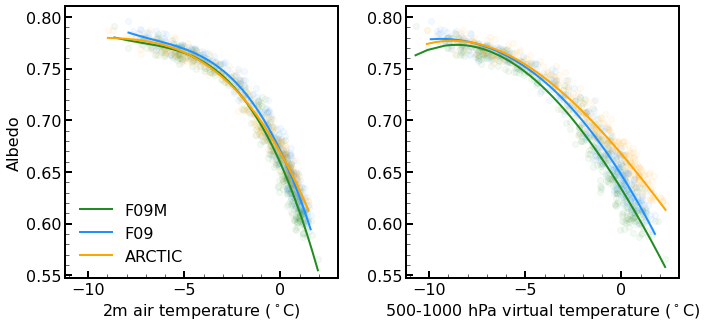

In [107]:
fig = plt.figure(figsize = (11,5))
gs=GridSpec(5,11)
plt.rcParams['axes.titlepad'] =14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_tick = 16
size_label = 16
size_text = 16
size_legend = 16
alpha_marker = 0.05
width_line = 2

#------------------------------------------T2m vs albedo------------------------------------------
ax1 = plt.subplot(gs[0:5,0:5])

plt.scatter(f09_1pctCO2_4xext_avg_TREFHT_JJA-273.15, f09_1pctCO2_4xext_avg_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_1pctCO2_4xext_avg_TREFHT_JJA-273.15, f09_nohacks_1pctCO2_4xext_avg_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_1pctCO2_4xext_avg_TREFHT_JJA-273.15, ARCTIC_1pctCO2_4xext_avg_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.plot(f09_1pctCO2_4xext_avg_TREFHT_JJA.sortby(f09_1pctCO2_4xext_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_1pctCO2_4xext_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_1pctCO2_4xext_avg_TREFHT_JJA.sortby(f09_nohacks_1pctCO2_4xext_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_nohacks_1pctCO2_4xext_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_1pctCO2_4xext_avg_TREFHT_JJA.sortby(ARCTIC_1pctCO2_4xext_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(ARCTIC_1pctCO2_4xext_avg_TREFHT_JJA), color='orange', linewidth=width_line, label='ARCTIC')
#plt.title('(a) ARCTIC - F09M', fontsize=size_text)

ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

ax1.set_xlim([-11.2, 3])
ax1.set_ylim([0.547, 0.81])
ax1.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax1.set_ylabel("Albedo", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)

#------------------------------------------Lower troposphere virtual temp vs albedo------------------------------------------
ax2 = plt.subplot(gs[0:5,6:11])

plt.scatter(f09_1pctCO2_4xext_avg_Tv_JJA-273.15, f09_1pctCO2_4xext_avg_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_1pctCO2_4xext_avg_Tv_JJA-273.15, f09_nohacks_1pctCO2_4xext_avg_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_1pctCO2_4xext_avg_Tv_JJA-273.15, ARCTIC_1pctCO2_4xext_avg_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.plot(f09_1pctCO2_4xext_avg_Tv_JJA.sortby(f09_1pctCO2_4xext_avg_Tv_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(f09_1pctCO2_4xext_avg_Tv_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_1pctCO2_4xext_avg_Tv_JJA.sortby(f09_nohacks_1pctCO2_4xext_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(f09_nohacks_1pctCO2_4xext_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_1pctCO2_4xext_avg_Tv_JJA.sortby(ARCTIC_1pctCO2_4xext_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(ARCTIC_1pctCO2_4xext_avg_Tv_JJA), color='orange', linewidth=width_line, label='ARCTIC')
#plt.title('(b) ARCTIC - F09', fontsize=size_text)

#ax2.legend(loc='lower right', frameon=False, prop={'size':size_legend}, ncol=1)

ax2.set_xlim([-11.2, 3])
ax2.set_ylim([0.547, 0.81])
ax2.set_xlabel("500-1000 hPa virtual temperature ($^\circ$C)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)

plt.subplots_adjust(wspace=0.25)
plt.savefig(
    home_dir+"2022-VR-dynamic-GrIS/github/plot/Scatter_T2m_albedo_vT_lowertropo_albedo.png",
    dpi=500,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

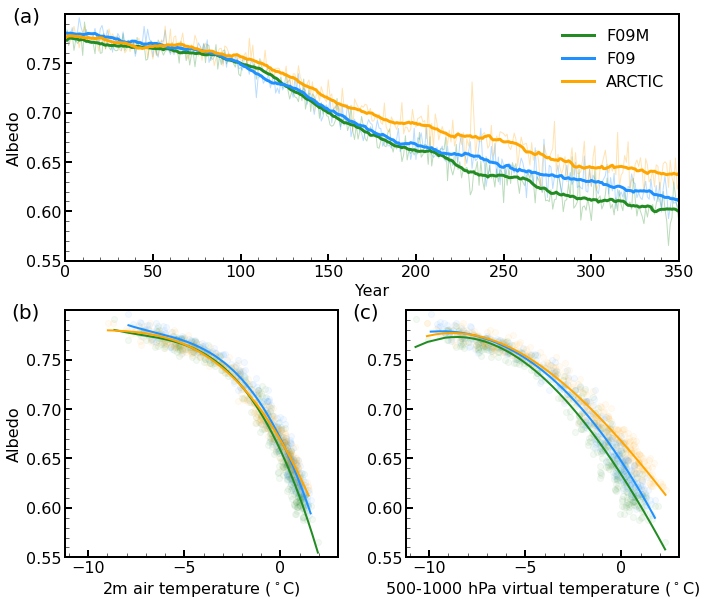

In [18]:
fig = plt.figure(figsize = (11,10))
gs=GridSpec(10,11)
plt.rcParams['axes.titlepad'] =14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_tick = 16
size_label = 16
size_text = 20
size_legend = 16
alpha_marker = 0.05
width_line = 2

#------------------------------------------JJA albedo------------------------------------------
ax0 = plt.subplot(gs[0:5,:])

ax0.plot(np.arange(1,351), f09_avg_albedo_JJA, color='forestgreen', linewidth=1, alpha=0.3)
ax0.plot(np.arange(1,351), f09_nohacks_avg_albedo_JJA, color='dodgerblue', linewidth=1, alpha=0.3)
ax0.plot(np.arange(1,351), ARCTIC_avg_albedo_JJA, color='orange', linewidth=1, alpha=0.3)

f09_avg_albedo_JJA_rm = f09_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()
f09_nohacks_avg_albedo_JJA_rm = f09_nohacks_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()
ARCTIC_avg_albedo_JJA_rm = ARCTIC_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()

ax0.plot(np.arange(1,351), f09_avg_albedo_JJA_rm, color='forestgreen', linewidth=3, label='F09M')
ax0.plot(np.arange(1,351), f09_nohacks_avg_albedo_JJA_rm, color='dodgerblue', linewidth=3, label='F09')
ax0.plot(np.arange(1,351), ARCTIC_avg_albedo_JJA_rm, color='orange', linewidth=3, label='ARCTIC')

ax0.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

ax0.set_xlim([0, 350])
ax0.set_ylim([0.55, 0.8])
ax0.set_xlabel('Year', fontsize=size_label)
ax0.set_ylabel('Albedo', fontsize=size_label)
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0.55,0.76,0.05))
ax0.tick_params(which="major", length=7, width=2, direction="in")
ax0.tick_params(which="minor", length=4, direction="in")
ax0.tick_params(labelsize=size_tick)
plt.text(-30, 0.792, '(a)', fontsize=size_text)

#------------------------------------------T2m vs albedo------------------------------------------
ax1 = plt.subplot(gs[5:10,0:5])

plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_avg_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_avg_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_avg_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, label='ARCTIC')

ax1.set_xlim([-11.2, 3])
ax1.set_ylim([0.55, 0.8])
ax1.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax1.set_ylabel("Albedo", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0.55,0.76,0.05))
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)
plt.text(-14, 0.792, '(b)', fontsize=size_text)

#------------------------------------------Lower troposphere virtual temp vs albedo------------------------------------------
ax2 = plt.subplot(gs[5:10,6:11])

plt.scatter(f09_avg_Tv_JJA-273.15, f09_avg_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_avg_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_avg_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, label='ARCTIC')

ax2.set_xlim([-11.2, 3])
ax2.set_ylim([0.55, 0.8])
ax2.set_xlabel("500-1000 hPa virtual temperature ($^\circ$C)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0.55,0.76,0.05))
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)
plt.text(-14, 0.792, '(c)', fontsize=size_text)


plt.subplots_adjust(wspace=0.25, hspace=5)
plt.savefig(
    home_dir+"2022-VR-dynamic-GrIS/github/plot/tseries_albedo_scatter_T2m_albedo_vT_lowertropo_albedo.png",
    dpi=500,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

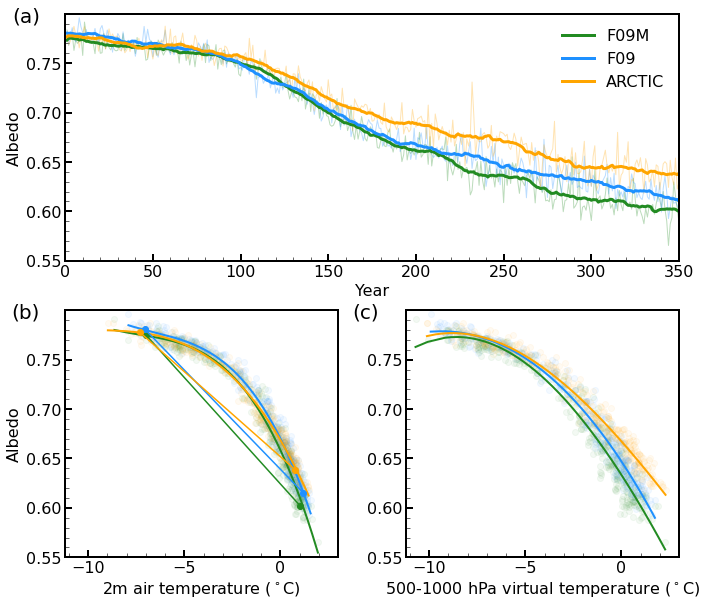

In [97]:
# Add straight lines
fig = plt.figure(figsize = (11,10))
gs=GridSpec(10,11)
plt.rcParams['axes.titlepad'] =14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_tick = 16
size_label = 16
size_text = 20
size_legend = 16
alpha_marker = 0.05
width_line = 2

#------------------------------------------JJA albedo------------------------------------------
ax0 = plt.subplot(gs[0:5,:])

ax0.plot(np.arange(1,351), f09_avg_albedo_JJA, color='forestgreen', linewidth=1, alpha=0.3)
ax0.plot(np.arange(1,351), f09_nohacks_avg_albedo_JJA, color='dodgerblue', linewidth=1, alpha=0.3)
ax0.plot(np.arange(1,351), ARCTIC_avg_albedo_JJA, color='orange', linewidth=1, alpha=0.3)

f09_avg_albedo_JJA_rm = f09_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()
f09_nohacks_avg_albedo_JJA_rm = f09_nohacks_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()
ARCTIC_avg_albedo_JJA_rm = ARCTIC_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()

ax0.plot(np.arange(1,351), f09_avg_albedo_JJA_rm, color='forestgreen', linewidth=3, label='F09M')
ax0.plot(np.arange(1,351), f09_nohacks_avg_albedo_JJA_rm, color='dodgerblue', linewidth=3, label='F09')
ax0.plot(np.arange(1,351), ARCTIC_avg_albedo_JJA_rm, color='orange', linewidth=3, label='ARCTIC')

ax0.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

ax0.set_xlim([0, 350])
ax0.set_ylim([0.55, 0.8])
ax0.set_xlabel('Year', fontsize=size_label)
ax0.set_ylabel('Albedo', fontsize=size_label)
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0.55,0.76,0.05))
ax0.tick_params(which="major", length=7, width=2, direction="in")
ax0.tick_params(which="minor", length=4, direction="in")
ax0.tick_params(labelsize=size_tick)
plt.text(-30, 0.792, '(a)', fontsize=size_text)

#------------------------------------------T2m vs albedo------------------------------------------
ax1 = plt.subplot(gs[5:10,0:5])

plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_avg_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_avg_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_avg_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, label='ARCTIC')

# Straight line connecting PI and end albedo and T2m
plt.plot([f09_avg_TREFHT_PI-273.15, f09_avg_TREFHT_end-273.15], [f09_avg_albedo_PI, f09_avg_albedo_end], marker='o', color='forestgreen')
plt.plot([f09_nohacks_avg_TREFHT_PI-273.15, f09_nohacks_avg_TREFHT_end-273.15], [f09_nohacks_avg_albedo_PI, f09_nohacks_avg_albedo_end], marker='o', color='dodgerblue')
plt.plot([ARCTIC_avg_TREFHT_PI-273.15, ARCTIC_avg_TREFHT_end-273.15], [ARCTIC_avg_albedo_PI, ARCTIC_avg_albedo_end], marker='o', color='orange')

ax1.set_xlim([-11.2, 3])
ax1.set_ylim([0.55, 0.8])
ax1.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax1.set_ylabel("Albedo", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0.55,0.76,0.05))
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)
plt.text(-14, 0.792, '(b)', fontsize=size_text)

#------------------------------------------Lower troposphere virtual temp vs albedo------------------------------------------
ax2 = plt.subplot(gs[5:10,6:11])

plt.scatter(f09_avg_Tv_JJA-273.15, f09_avg_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_avg_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_avg_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, label='ARCTIC')

ax2.set_xlim([-11.2, 3])
ax2.set_ylim([0.55, 0.8])
ax2.set_xlabel("500-1000 hPa virtual temperature ($^\circ$C)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0.55,0.76,0.05))
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)
plt.text(-14, 0.792, '(c)', fontsize=size_text)


plt.subplots_adjust(wspace=0.25, hspace=5)
plt.savefig(
    home_dir+"2022-VR-dynamic-GrIS/github/plot/tseries_albedo_scatter_T2m_albedo_vT_lowertropo_albedo_line.png",
    dpi=500,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

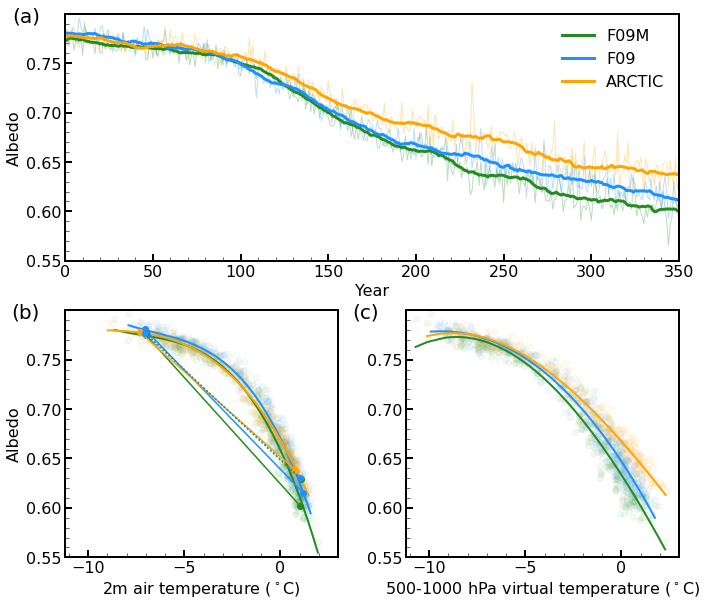

In [19]:
## Add straight lines
fig = plt.figure(figsize = (11,10))
gs=GridSpec(10,11)
plt.rcParams['axes.titlepad'] =14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_tick = 16
size_label = 16
size_text = 20
size_legend = 16
alpha_marker = 0.05
width_line = 2

#------------------------------------------JJA albedo------------------------------------------
ax0 = plt.subplot(gs[0:5,:])

ax0.plot(np.arange(1,351), f09_avg_albedo_JJA, color='forestgreen', linewidth=1, alpha=0.3)
ax0.plot(np.arange(1,351), f09_nohacks_avg_albedo_JJA, color='dodgerblue', linewidth=1, alpha=0.3)
ax0.plot(np.arange(1,351), ARCTIC_avg_albedo_JJA, color='orange', linewidth=1, alpha=0.3)

f09_avg_albedo_JJA_rm = f09_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()
f09_nohacks_avg_albedo_JJA_rm = f09_nohacks_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()
ARCTIC_avg_albedo_JJA_rm = ARCTIC_avg_albedo_JJA.rolling(year=20, center=True, min_periods=2).mean()

ax0.plot(np.arange(1,351), f09_avg_albedo_JJA_rm, color='forestgreen', linewidth=3, label='F09M')
ax0.plot(np.arange(1,351), f09_nohacks_avg_albedo_JJA_rm, color='dodgerblue', linewidth=3, label='F09')
ax0.plot(np.arange(1,351), ARCTIC_avg_albedo_JJA_rm, color='orange', linewidth=3, label='ARCTIC')

ax0.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

ax0.set_xlim([0, 350])
ax0.set_ylim([0.55, 0.8])
ax0.set_xlabel('Year', fontsize=size_label)
ax0.set_ylabel('Albedo', fontsize=size_label)
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0.55,0.76,0.05))
ax0.tick_params(which="major", length=7, width=2, direction="in")
ax0.tick_params(which="minor", length=4, direction="in")
ax0.tick_params(labelsize=size_tick)
plt.text(-30, 0.792, '(a)', fontsize=size_text)

#------------------------------------------T2m vs albedo------------------------------------------
ax1 = plt.subplot(gs[5:10,0:5])

plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_avg_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_avg_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_avg_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, label='ARCTIC')

# Straight line connecting PI and end albedo and T2m
plt.plot([f09_avg_TREFHT_PI-273.15, f09_avg_TREFHT_end-273.15], [f09_avg_albedo_PI, f09_avg_albedo_end], marker='o', color='forestgreen')
plt.plot([f09_nohacks_avg_TREFHT_PI-273.15, f09_nohacks_avg_TREFHT_end-273.15], [f09_nohacks_avg_albedo_PI, f09_nohacks_avg_albedo_end], marker='o', color='dodgerblue')
plt.plot([ARCTIC_avg_TREFHT_PI-273.15, ARCTIC_avg_TREFHT_end-273.15], [ARCTIC_avg_albedo_PI, ARCTIC_avg_albedo_end], marker='o', color='orange')
plt.plot([ARCTIC_avg_TREFHT_adddT2mF09M_PI-273.15, ARCTIC_avg_TREFHT_adddT2mF09M_end-273.15], [ARCTIC_avg_albedo_adddT2mF09M_PI, ARCTIC_avg_albedo_adddT2mF09M_end], marker='o', linestyle=':', color='forestgreen')
plt.plot([ARCTIC_avg_TREFHT_adddT2mF09_PI-273.15, ARCTIC_avg_TREFHT_adddT2mF09_end-273.15], [ARCTIC_avg_albedo_adddT2mF09_PI, ARCTIC_avg_albedo_adddT2mF09_end], marker='o', linestyle=':', color='dodgerblue')

ax1.set_xlim([-11.2, 3])
ax1.set_ylim([0.55, 0.8])
ax1.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax1.set_ylabel("Albedo", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0.55,0.76,0.05))
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)
plt.text(-14, 0.792, '(b)', fontsize=size_text)

#------------------------------------------Lower troposphere virtual temp vs albedo------------------------------------------
ax2 = plt.subplot(gs[5:10,6:11])

plt.scatter(f09_avg_Tv_JJA-273.15, f09_avg_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_avg_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_avg_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, label='ARCTIC')

ax2.set_xlim([-11.2, 3])
ax2.set_ylim([0.55, 0.8])
ax2.set_xlabel("500-1000 hPa virtual temperature ($^\circ$C)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0.55,0.76,0.05))
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)
plt.text(-14, 0.792, '(c)', fontsize=size_text)


plt.subplots_adjust(wspace=0.25, hspace=5)
plt.savefig(
    home_dir+"2022-VR-dynamic-GrIS/github/plot/tseries_albedo_scatter_T2m_albedo_vT_lowertropo_albedo_line2.png",
    dpi=500,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

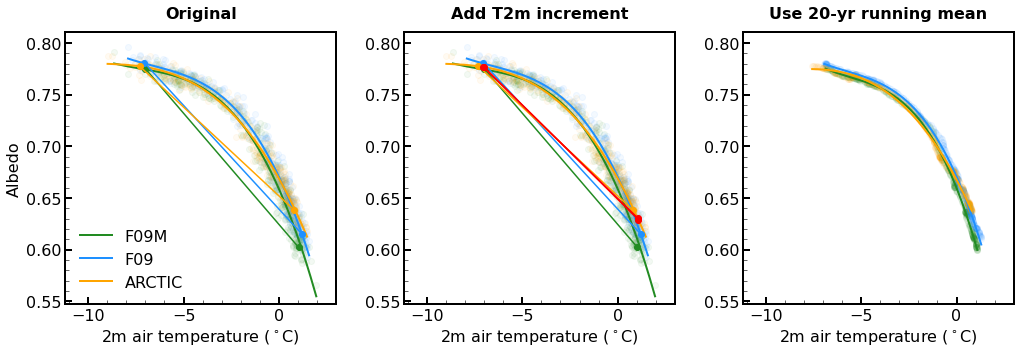

In [20]:
## Compare
fig = plt.figure(figsize = (17,5))
gs=GridSpec(5,17)
plt.rcParams['axes.titlepad'] =14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_tick = 16
size_label = 16
size_title = 16
size_text = 16
size_legend = 16
alpha_marker = 0.05
width_line = 2

#------------------------------------------T2m vs albedo------------------------------------------
ax1 = plt.subplot(gs[0:5,0:5])

plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_avg_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_avg_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_avg_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, label='ARCTIC')
#plt.title('(a) ARCTIC - F09M', fontsize=size_text)

# Straight line connecting PI and end albedo and T2m
plt.plot([f09_avg_TREFHT_PI-273.15, f09_avg_TREFHT_end-273.15], [f09_avg_albedo_PI, f09_avg_albedo_end], marker='o', color='forestgreen')
plt.plot([f09_nohacks_avg_TREFHT_PI-273.15, f09_nohacks_avg_TREFHT_end-273.15], [f09_nohacks_avg_albedo_PI, f09_nohacks_avg_albedo_end], marker='o', color='dodgerblue')
plt.plot([ARCTIC_avg_TREFHT_PI-273.15, ARCTIC_avg_TREFHT_end-273.15], [ARCTIC_avg_albedo_PI, ARCTIC_avg_albedo_end], marker='o', color='orange')

ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

ax1.set_xlim([-11.2, 3])
ax1.set_ylim([0.547, 0.81])
ax1.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax1.set_ylabel("Albedo", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)
ax1.set_title('Original', fontsize=size_title, fontweight='bold')

#------------------------------------------T2m vs albedo------------------------------------------
ax2 = plt.subplot(gs[0:5,6:11])

plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_avg_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_avg_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_avg_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, label='ARCTIC')
#plt.title('(b) ARCTIC - F09', fontsize=size_text)

# Straight line connecting PI and end albedo and T2m
plt.plot([f09_avg_TREFHT_PI-273.15, f09_avg_TREFHT_end-273.15], [f09_avg_albedo_PI, f09_avg_albedo_end], marker='o', color='forestgreen')
plt.plot([f09_nohacks_avg_TREFHT_PI-273.15, f09_nohacks_avg_TREFHT_end-273.15], [f09_nohacks_avg_albedo_PI, f09_nohacks_avg_albedo_end], marker='o', color='dodgerblue')
plt.plot([ARCTIC_avg_TREFHT_PI-273.15, ARCTIC_avg_TREFHT_end-273.15], [ARCTIC_avg_albedo_PI, ARCTIC_avg_albedo_end], marker='o', color='orange')
plt.plot([ARCTIC_avg_TREFHT_adddT2mF09M_PI-273.15, ARCTIC_avg_TREFHT_adddT2mF09M_end-273.15], [ARCTIC_avg_albedo_adddT2mF09M_PI, ARCTIC_avg_albedo_adddT2mF09M_end], marker='o', color='red')
plt.plot([ARCTIC_avg_TREFHT_adddT2mF09_PI-273.15, ARCTIC_avg_TREFHT_adddT2mF09_end-273.15], [ARCTIC_avg_albedo_adddT2mF09_PI, ARCTIC_avg_albedo_adddT2mF09_end], marker='o', color='red')

ax2.set_xlim([-11.2, 3])
ax2.set_ylim([0.547, 0.81])
ax2.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)
ax2.set_title('Add T2m increment', fontsize=size_title, fontweight='bold')

#------------------------------------------20-year running mean------------------------------------------
ax3 = plt.subplot(gs[0:5,12:17])

plt.scatter(f09_avg_TREFHT_JJA_rm-273.15, f09_avg_albedo_JJA_rm, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA_rm-273.15, f09_nohacks_avg_albedo_JJA_rm, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA_rm-273.15, ARCTIC_avg_albedo_JJA_rm, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.plot(f09_avg_TREFHT_JJA_rm.sortby(f09_avg_TREFHT_JJA_rm)-273.15, xr.DataArray(f09_albedo_JJA_pred_rm).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA_rm), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_TREFHT_JJA_rm.sortby(f09_nohacks_avg_TREFHT_JJA_rm)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred_rm).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA_rm), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_TREFHT_JJA_rm.sortby(ARCTIC_avg_TREFHT_JJA_rm)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred_rm).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA_rm), color='orange', linewidth=width_line, label='ARCTIC')
#plt.title('(b) ARCTIC - F09', fontsize=size_text)

# Straight line connecting PI and end albedo and T2m


ax3.set_xlim([-11.2, 3])
ax3.set_ylim([0.547, 0.81])
ax3.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which="major", length=7, width=2, direction="in")
ax3.tick_params(which="minor", length=4, direction="in")
ax3.tick_params(labelsize=size_tick)
ax3.set_title('Use 20-yr running mean', fontsize=size_title, fontweight='bold')


plt.subplots_adjust(wspace=0.25)
plt.savefig(
    home_dir+"2022-VR-dynamic-GrIS/github/plot/Scatter_T2m_albedo_line.png",
    dpi=500,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

In [21]:
## Calculate slope
print('F09M: ', ((f09_avg_albedo_end-f09_avg_albedo_PI)/(f09_avg_TREFHT_end-f09_avg_TREFHT_PI)).round(decimals=3).values)
print('F09: ', ((f09_nohacks_avg_albedo_end-f09_nohacks_avg_albedo_PI)/(f09_nohacks_avg_TREFHT_end-f09_nohacks_avg_TREFHT_PI)).round(decimals=3).values)
print('ARCTIC: ', ((ARCTIC_avg_albedo_end-ARCTIC_avg_albedo_PI)/(ARCTIC_avg_TREFHT_end-ARCTIC_avg_TREFHT_PI)).round(decimals=3).values)
print('ARCTIC_adddT2mF09M: ', np.round(((ARCTIC_avg_albedo_adddT2mF09M_end-ARCTIC_avg_albedo_adddT2mF09M_PI)/(ARCTIC_avg_TREFHT_adddT2mF09M_end-ARCTIC_avg_TREFHT_adddT2mF09M_PI).values), decimals=3))
print('ARCTIC_adddT2mF09: ', np.round(((ARCTIC_avg_albedo_adddT2mF09_end-ARCTIC_avg_albedo_adddT2mF09_PI)/(ARCTIC_avg_TREFHT_adddT2mF09_end-ARCTIC_avg_TREFHT_adddT2mF09_PI).values), decimals=3))

F09M:  -0.022
F09:  -0.02
ARCTIC:  -0.017
ARCTIC_adddT2mF09M:  [-0.018]
ARCTIC_adddT2mF09:  [-0.018]
